## BnB DFS ##

In [101]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import math
from time import process_time



def DFS(dist_mat, heuristic="NN", cluster=False, n_clusters=3, h_freq=3, max_bottoms=10**2, opt_iter=10**2, mean=100, sigma=100):
    # dist_mat: nxn symmetric numpy array
    # heuristic: "NN" or "2opt"
    # cluster: True for clustered subproblems
    # n_clusters: number of sub problems to split into
    # max_bottoms: stopping criteria - number of times we've reached the bottom
    # opt_iter: stopping criterion for 2opt
    
    t1_start = process_time()
    
    inf = math.inf  # initial upper bound
    bestcost_array = []
    total_approx = []
    heuristic_array = []
    current_cost_array = []
    frontier_array = []
    node_count_array = []
    bound_array = []
    best_path = []
    best_dist = 0
    nodes = 0
    iter = 0
    bottoms = 0

    N = len(dist_mat)

    # 2-opt heuristic function
    def two_opt(state, from_cluster, operations):
        
        # special cost function for 2opt
        def cost_func(state, start_node):
            cost = 0
            cost += dist_mat.loc[state[-1], start_node] # start point consistancy
            for i in range(len(state) - 1):
                cost += dist_mat.loc[state[i], state[i + 1]]
            return cost

        # exchange 2 edges
        def switch_two(state, pivot, i):
            state[pivot], state[i] = state[i], state[pivot]
            return state
        
        if len(state) == N:
            return 0
        if len(state) == 1:
            return 0
        
        # initialize
        start_node = state[0]
        unexplored = [i for i in range(N) if i not in state]
        new_state = unexplored
        current_cost = cost_func(new_state, start_node)

        # begin 2-opt algorithm
        for j in range(operations):

            state = new_state
            pivot = random.choice(range(len(new_state)))  # index of pivot node
                                  
            # switch edges uses pivot with every other node
            for i in range(len(new_state)):
                if i != pivot:
                    opt = switch_two(state, pivot, i)
                    opt_cost = cost_func(opt, start_node)

                    if opt_cost < current_cost:
                        current_cost = opt_cost
                        new_state = opt  # improved tours are used in the next round

        #  check if called from the cluster heuristic: we do not loop within clusters
        if not cluster:
            current_cost += dist_mat.loc[new_state[-1], state[0]]

        return current_cost

    # cluster: create subproblems
    def cluster_heuristic(state):
        
        # cluster on unexpanded nodes
        unexpanded_nodes = [i for i in range(N) if i not in state] # nodes left to explore
        unexpanded_matrix = dist_mat.take(unexpanded_nodes, axis=0) # subset dist matrix by unexpanded nodes
        unexpanded_matrix = unexpanded_matrix.take(unexpanded_nodes, axis=1)
        
        # kmeans cluster on paths between unvisited cities
        kmeans = KMeans(n_clusters=n_clusters, random_state=1999).fit(unexpanded_matrix.to_numpy())  
        cluster_dict = dict(zip(unexpanded_nodes, kmeans.labels_))
        
        h = 0
        
        # solve each subproblem separately grouped by kmeans partition
        for i in range(n_clusters):

            sub_path = [j for j in unexpanded_nodes if cluster_dict[j] == i]  # subpath of nodes in cluster i

            # rarely clusters will be empty
            if sub_path == []:
                continue

            # track and connect paths between clusters
            if i != 0 and i != n_clusters - 1:
                h += dist_mat.loc[sub_path_end, sub_path[0]]
            sub_path_end = sub_path[-1]

            # there are issues if subpaths are too small
            if len(sub_path) < 3:
                h += mean

            # loop back to start at the end of the last cluster
            if i == n_clusters - 1:
                h += dist_mat.loc[sub_path_end, state[0]]

            # solve sub problem and add on subpath distance
            else:
                
                remaining = [j for j in unexpanded_nodes if j not in sub_path]
                pseudo_state = [k for k in state if k not in sub_path and k not in remaining]
                
                if heuristic == '2opt':
                    sub_path_dist = two_opt(pseudo_state, from_cluster = True, operations = opt_iter)
                elif heuristic == 'NN':
                    sub_path_dist = NN(pseudo_state, from_cluster = True)

                h += sub_path_dist

        return h

    def NN(state, from_cluster):

        dist_mat_tilde = pd.DataFrame(dist_mat).copy().to_numpy()

        dist_mat_tilde[state[:-1]] = inf
        dist_mat_tilde[:, state[:-1]] = inf
        np.fill_diagonal(dist_mat_tilde, inf)

        cost = 0
        next = state[-1]
        NN_iter = 0

        while NN_iter <= N - len(state) - 1:
            ind = dist_mat_tilde[next, :].argmin()  # city with min dist from current
            cost_new = dist_mat_tilde[next, ind]
            dist_mat_tilde[:, next] = inf

            cost += cost_new
            next = ind
            NN_iter += 1
        
        #  check if called from the cluster heuristic: we do not loop within clusters
        if not from_cluster:
            cost += dist_mat.loc[next, state[0]]

        return cost

    # calculates current cost + heuristic (approximation of future cost)
    def objective_function(state, calculate_heuristic):
        
        if len(state) < 1:
            return U

        if calculate_heuristic:
            # calculate heuristic using clustering
            if cluster == True:
                if len(state) <= n_clusters:  # don't cluster unless the unexplored path is long enough
                    h = cluster_heuristic(state)
                    
                # too small for clustering    
                elif heuristic == '2opt':
                    h = two_opt(state, from_cluster = False, operations = opt_iter)
                elif heuristic == 'NN':
                    h = NN(state, from_cluster = False)

            # calculate heuristic whole
            elif cluster == False:
                if heuristic == "2opt":
                    h = two_opt(state, from_cluster = False, operations = opt_iter)
                elif heuristic == "NN":
                    h = NN(state, from_cluster = False)

        # no heuristic calculation - rough approx
        elif not calculate_heuristic:
            h = (N - len(state))*(mean + sigma)

        cost = 0
        
        for i in range(len(state) - 1):
            cost += dist_mat.loc[state[i], state[i+1]]

        # we are at the end
        if len(state) == len(dist_mat):
            cost += dist_mat.loc[state[-1], state[0]]
        
        if len(state) == 1:
            h = 0
            
        cost_approx = cost + h

        heuristic_array.append(h)
        current_cost_array.append(cost)
        total_approx.append(cost_approx)

        return cost_approx

    # appends newly generated nodes to frontier
    def gen_front(current, frontier, N):

        nums = [i for i in range(N)]

        for y in current:
            if y in nums:
                nums.remove(y)
        for i in range(len(nums)):
            t = current[:]
            t.append(nums[i])
            frontier.append(t)
        return frontier

    frontier = [[i] for i in range(N)]
    calculate_heuristic = True
    U = inf
    
    while frontier != [] and bottoms < max_bottoms:

        frontier_array.append(len(frontier))
        
        new_path = frontier.pop()
        if iter % h_freq == 0:
            calculate_heuristic = False

        path_cost = objective_function(new_path, calculate_heuristic)
        calculate_heuristic = True

        if path_cost > U:
            continue
        
        # we have a complete path
        elif len(new_path) == N:
            U = path_cost
            best_path = new_path
            best_dist = path_cost
            bestcost_array.append(path_cost)
            best_path.append(0)
            bottoms += 1

        else:
            frontier = gen_front(new_path, frontier, N)
            
        # 10 min hard-stop
        if process_time() - t1_start >= 600:
            return best_dist, 600
        
        nodes += 1
        iter += 1      
        node_count_array.append(nodes)
        bound_array.append(U)
        
    # CPU time    
    t1_stop = process_time()
    cpu_time = t1_stop - t1_start  
    
    # Plots      
    fig, axes = plt.subplots(1, 3, figsize=(25, 8))
    fig.tight_layout(pad = 8)   
    
    plt.subplot(1, 5, 1)
    plt.plot(bestcost_array, linewidth=5.5, color = 'red')
    plt.title('Progression path cost')
    plt.ylabel('Cost')
    plt.xlabel('Iteration')
  
    plt.subplot(1, 5, 2)
    plt.plot(bound_array, linewidth=5.5)
    plt.title('Upper-bound')
    plt.ylabel('Cost Bound')
    plt.xlabel('Iteration')    

    plt.subplot(1, 5, 3)
    plt.plot(total_approx, label = "f + h")
    plt.plot(current_cost_array, label = "f")
    plt.plot(heuristic_array, label = "h")
    plt.title('Cost breakdown')
    plt.ylabel('Distance')
    plt.xlabel('Iteration') 
    plt.legend(fontsize=20)

    plt.subplot(1, 5, 4)
    plt.plot(frontier_array, linewidth=5.5, color = 'green')
    plt.title('Frontier size')
    plt.ylabel('Nodes in frontier')
    plt.xlabel('Iteration') 
    
    plt.subplot(1, 5, 5)
    plt.plot(node_count_array, linewidth=5.5, color = 'orange')
    plt.title('Nodes expanded')
    plt.ylabel('Total nodes expanded so far')
    plt.xlabel('Iteration') 
    plt.show()  
    
    return best_dist, cpu_time

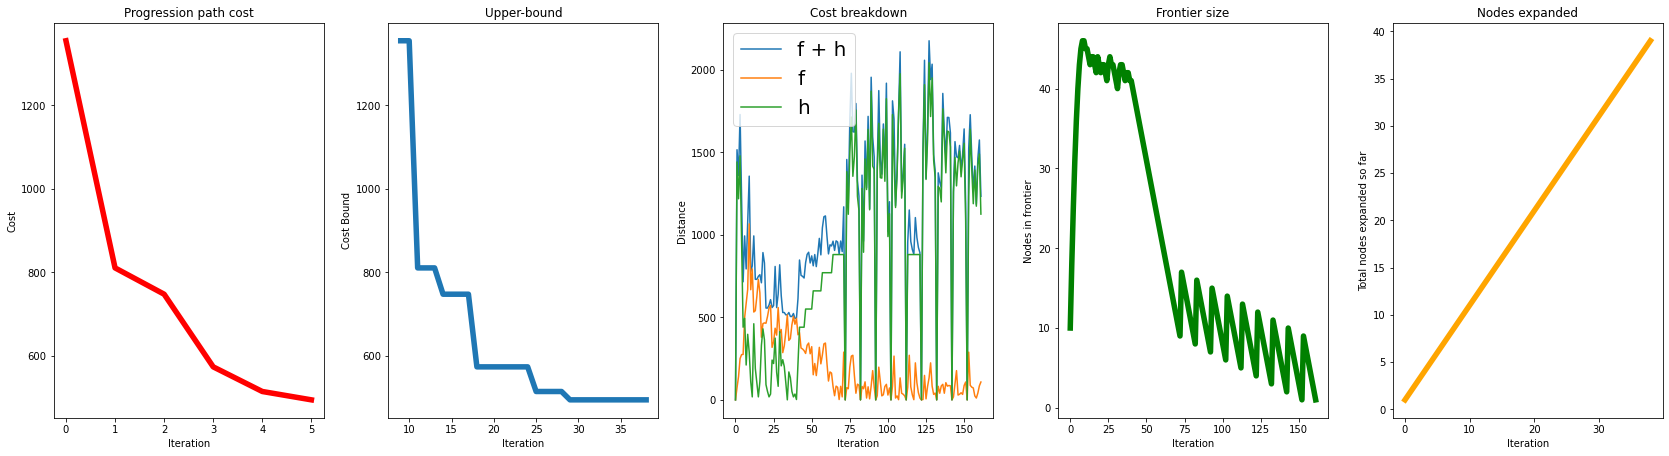

495.0 1.21875 268.0


In [102]:
import numpy as np
import pandas as pd
from python_tsp.exact import solve_tsp_dynamic_programming
from python_tsp.heuristics import solve_tsp_local_search

def write_distance_matrix(n, mean, sigma):
    distance_matrix = np.zeros((n, n))
    random_distance = []
    num_distance = int(n * (n-1) / 2)
    for _ in range(num_distance):
        distance = 0
        while distance <= 0:
            distance = np.random.normal(mean, sigma)

        random_distance.append(round(distance))
    
    iu = np.triu_indices(n, 1)
    distance_matrix[iu] = random_distance
    distance_matrix += distance_matrix.T

    return distance_matrix
    

mean = 10
sigma = 100
N = 10
h_freq = 5
n_clusters = N//2
opt_iter = 10**2
max_bottoms = N
distance_matrix = pd.DataFrame(write_distance_matrix(N, mean, sigma))

dist, cpu_time = DFS(distance_matrix, heuristic = "NN", cluster = True, n_clusters = n_clusters, h_freq = h_freq, max_bottoms = max_bottoms, opt_iter = opt_iter, mean = mean, sigma = sigma)

permutation, optimal = solve_tsp_local_search(distance_matrix.to_numpy())
#solve_tsp_local_search #heuristic, approx
#solve_tsp_dynamic_programming #optimal
print(dist, cpu_time, optimal)